# Report 2

## Task 1

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os
from PIL import Image
from sklearn.decomposition import PCA
import glob
from scipy.spatial.distance import cdist


filename = "walking_1"
folder = "hw2data/train/"

vals = np.load(folder + filename + ".npy")

print(vals.shape)

xyz = np.reshape( vals[:, :], [38, 3, -1])

print(xyz.shape)

(114, 100)
(38, 3, 100)


In [2]:
r = 1000
xroot, yroot, zroot = xyz[0,0,0], xyz[0, 0, 1], xyz[0,0, 2]

I = np.array(
        [1, 2, 3, 4, 5, 6, 1, 8, 9, 10, 11, 12, 1, 14, 15, 16, 17, 18, 19, 16, 21, 22, 23, 25, 26, 24, 28, 16, 30, 31,
         32, 33, 34, 35, 36, 37]) - 1
J = np.array(
        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38]) - 1



for joint in range(1, xyz.shape[2]):

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    for move in range(0, I.shape[0]):
        xline = np.array([xyz[I[move], 0, joint], xyz[J[move], 0, joint]])
        yline = np.array([xyz[I[move], 1, joint], xyz[J[move], 1, joint]])
        zline = np.array([xyz[I[move], 2, joint], xyz[J[move], 2, joint]])
        ax.plot(xline, yline, zline)
    
    ax.set_xlim([-r + xroot, r + xroot])
    ax.set_ylim([-r + yroot, r + yroot])
    ax.set_zlim([-r + zroot, r + zroot])

    plt.savefig(f"{joint}.png")
    plt.close()


images = [Image.open(f"{n}.png") for n in range(1, xyz.shape[2])]
images[0].save(filename + '.gif', save_all=True, append_images=images[1:], duration=30, loop=0)

for n in range(1, xyz.shape[2]):
    os.remove(f"{n}.png")

## Task 1

In [ ]:
movements = ["jumping", "running", "walking"]

X_train = []
for movement in movements:
    files = sorted(glob.glob(f'hw2data/train/{movement}_*.npy'))
    for file in files:
        data = np.load(file)
        X_train.append(data)
X_train = np.hstack(X_train) # (114, 1500)

print(X_train.shape)

X = X_train.T


pca1 = PCA()
pca1.fit(X)



(114, 1500)


PCA()

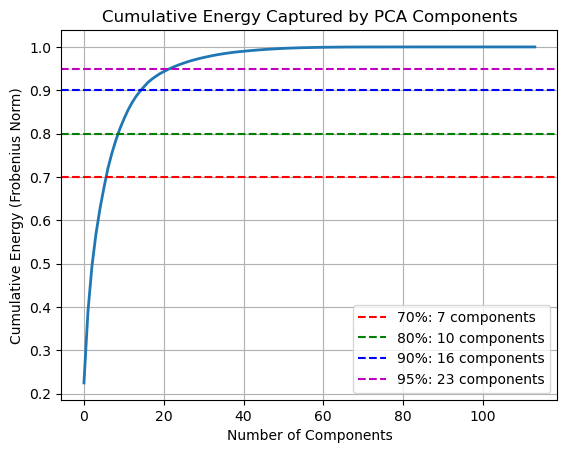

Components required: 70% - 7, 80% - 10, 90% - 16, 95% - 23


In [4]:
singular_values_sq = pca1.singular_values_

total_energy = np.sum(singular_values_sq)

explained_energy = singular_values_sq / total_energy

cumulative_energy = np.cumsum(explained_energy)

thresholds = [0.7, 0.8, 0.9, 0.95]
k_values = [np.argmax(cumulative_energy >= t) + 1 for t in thresholds]

plt.figure()
plt.plot(cumulative_energy, linewidth=2)
colors = ['r', 'g', 'b', 'm']
for t, k, c in zip(thresholds, k_values, colors):
    plt.axhline(y=t, color=c, linestyle='--', label=f'{int(t*100)}%: {k} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Energy (Frobenius Norm)')
plt.legend()
plt.grid()
plt.title('Cumulative Energy Captured by PCA Components')
plt.show()

print(f"Components required: 70% - {k_values[0]}, 80% - {k_values[1]}, 90% - {k_values[2]}, 95% - {k_values[3]}")

## Task 2

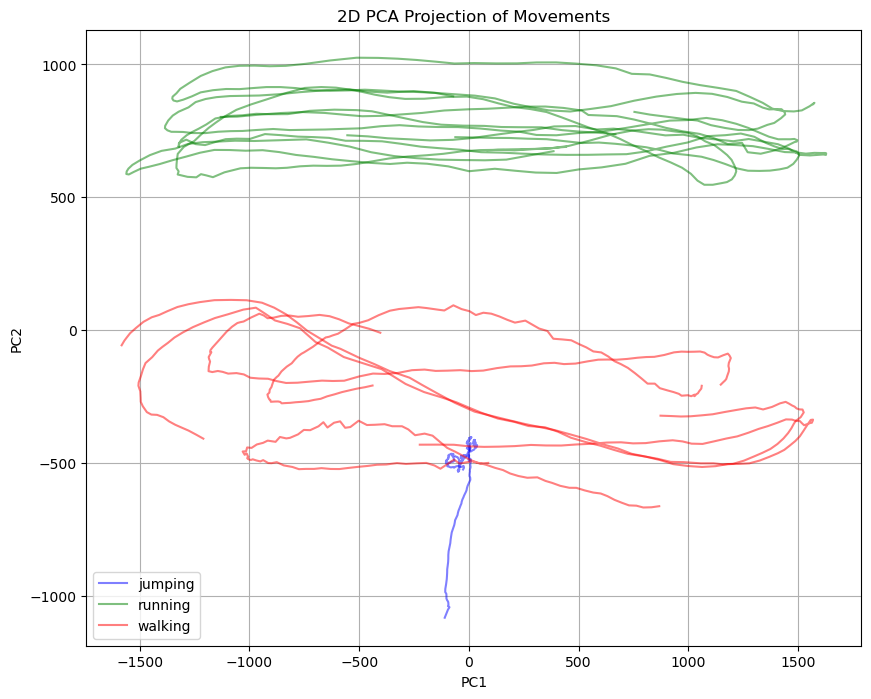

In [5]:
labels = np.repeat([0, 1, 2], repeats=5*100).reshape(15, 100).T.flatten()

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

samples_pca2 = [X_pca2[i*100:(i+1)*100] for i in range(15)]
samples_pca3 = [X_pca3[i*100:(i+1)*100] for i in range(15)]

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
for i, sample in enumerate(samples_pca2):
    movement = i // 5
    plt.plot(sample[:, 0], sample[:, 1], color=colors[movement], alpha=0.5, label=movements[movement] if i % 5 == 0 else "")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Projection of Movements')
plt.legend()
plt.grid()
plt.show()

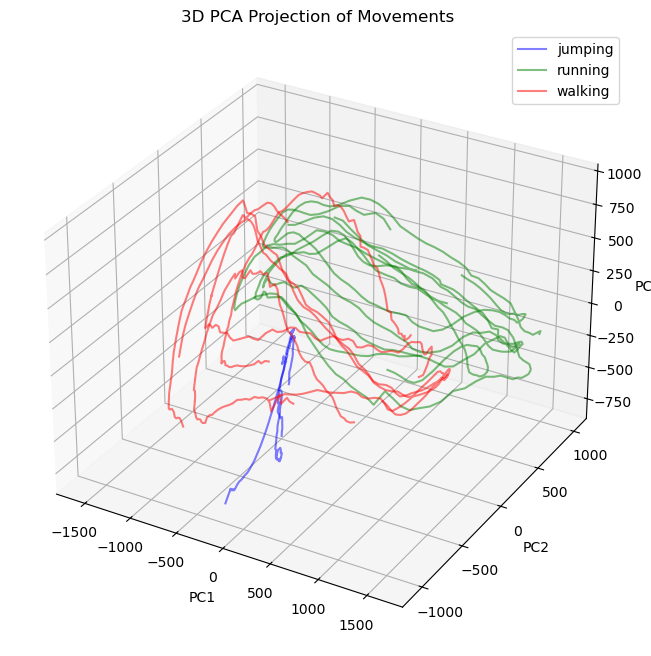

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, sample in enumerate(samples_pca3):
    movement = i //5
    ax.plot(sample[:, 0], sample[:, 1], sample[:, 2], color=colors[movement], alpha=0.5, label=movements[movement] if i%5 ==0 else "")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA Projection of Movements')
plt.legend()
plt.show()

## Task 3, 4, 5

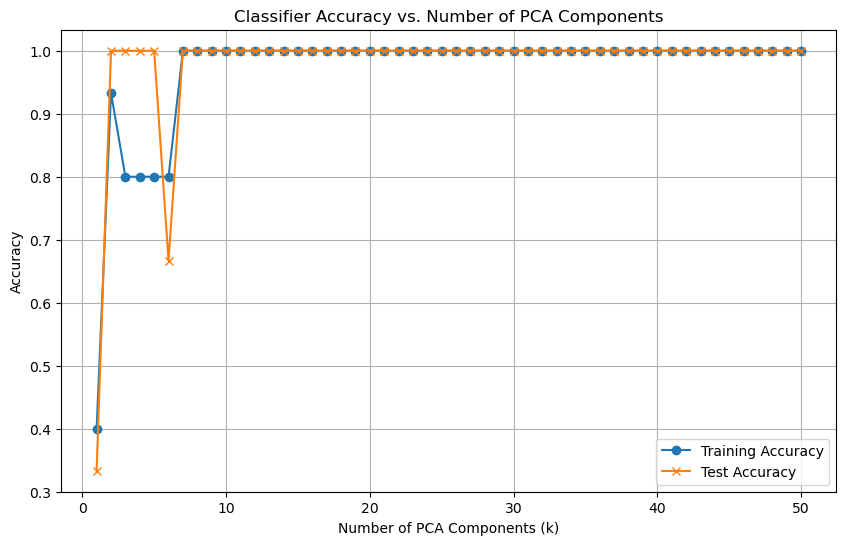

In [22]:
X = X_train.T  # shape: (1500, 114)
# Order of movements in your training set (as used when building X_train):
movements = ["jumping", "running", "walking"]

# We'll loop k from 1 to 50 and store training and test accuracies.
k_range = range(1, 51)
train_accuracies = []
test_accuracies = []

for k in k_range:
    pca = PCA(n_components=k)
    X_train_proj = pca.fit_transform(X)  # shape: (1500, k)
    samples_proj = [X_train_proj[i*100:(i+1)*100] for i in range(15)]
    sample_means = np.array([np.mean(sample, axis=0) for sample in samples_proj])
    
    gt_train = np.repeat([0, 1, 2], 5)
    centroids = {}
    for cl in np.unique(gt_train):
        centroids[cl] = np.mean(sample_means[gt_train == cl], axis=0)
    centroid_array = np.array([centroids[cl] for cl in sorted(centroids.keys())])

    distances = cdist(sample_means, centroid_array, metric='euclidean')
    pred_train = np.argmin(distances, axis=1)
    train_acc = accuracy_score(gt_train, pred_train)
    train_accuracies.append(train_acc)

    X_test_samples = []
    gt_test = []
    for cl, movement in enumerate(movements):
        test_files = sorted(glob.glob(f'hw2data/test/{movement}_*.npy'))
        if len(test_files) > 0:
            data = np.load(test_files[0])  # load the first test sample for each movement
            X_test_samples.append(data)
            gt_test.append(cl)

    if len(X_test_samples) > 0:
            test_means = []
            for sample in X_test_samples:
                # Each test sample is shape (114, 100); transpose to (100, 114) for PCA transform
                sample_proj = pca.transform(sample.T)  # shape: (100, k)
                sample_mean = np.mean(sample_proj, axis=0)
                test_means.append(sample_mean)
            test_means = np.array(test_means)
            distances_test = cdist(test_means, centroid_array, metric='euclidean')
            pred_test = np.argmin(distances_test, axis=1)
            test_acc = accuracy_score(gt_test, pred_test)
    else:
        test_acc = 0  # In case no test samples are found
    test_accuracies.append(test_acc)

plt.figure(figsize=(10, 6))
plt.plot(list(k_range), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(list(k_range), test_accuracies, label='Test Accuracy', marker='x')
plt.xlabel('Number of PCA Components (k)')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy vs. Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()
